## Cell Filtering and Quality Control
The purpose of this notebook is to filter our dataset for cells with adequate UMI contribution and low mitochondrial counts (not dead or dying).  
Adapted from B. Chen, June 2019.

---

Import the .py file with the QC class and function definitions

In [1]:
from QC import * 
import sys
sys.path.append('../')
from fcc_DRs import *

FIt-SNE repository not detected. Functionality will be disabled.


In [2]:
# read in mouse gene names to ignore human cell spike-ins
mousegenes = pd.read_csv('../inputs/mousenames.csv', header=None, index_col=0)
mousegenes.drop(axis=1, index=['kl000001.1','kl000002.1'], inplace=True)

In [3]:
%time colon = pd.read_csv('../inputs/GSM2743164_rep1_colon_rnaseq_filtered.tsv.gz', sep='\t', header=0, index_col=None, usecols=mousegenes.index) # only read in mouse genes

CPU times: user 14.9 s, sys: 586 ms, total: 15.5 s
Wall time: 15.5 s


In [4]:
# instantiate RNA_counts object from resulting DataFrame
%time colon = RNA_counts(colon)

CPU times: user 396 ms, sys: 115 ms, total: 511 ms
Wall time: 512 ms


In [5]:
colon.data.shape # check cells x genes

(1653, 25505)

Next, import the dataset for analysis. The QC preprocessing requires the data in three partitions.

1. Raw counts contained in a numpy.ndarray, as integers
2. Cell IDs in a 1-D numpy.ndarray, this can be barcodes or some other unique cell ID, with string datatype '<U16'
3. Gene IDs in a 1-D numpy.ndarray, these should be distinct gene names, with string datatype '<U16'

It also must be in a cell by gene, where each row represents a cell and each column represents a gene.

In [6]:
csr_counts=(colon.counts)
cellIDs=colon.cell_IDs
geneIDs=colon.gene_IDs

## Library_data object initialization for inflection point calculation and downstream operations

First, we pass the data organized above into a library_data object.

In [7]:
colon_lib=library_data(csr_counts,cellIDs,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Now we calculate the possible inflection points. This is done by finding the maximum distance between the cumulative sum curve and the secant line. These distances are then assigned a percentile score. By default, the inflection points are returned based off of four percentiles, 0, 15, 30 and 100. 0 represent the absolute maximum value for the aformentioned distance. 

A 15-30th percentile inflection point as to capture more libraries in preprocessing, using the 0th precentile runs the risk of cutting out useful, though relatively lower quality libraries. 

Inflection point at [ 776  862  985 1189 1652] for [0, 10, 25, 50, 100] percentiles of greatest secant distances


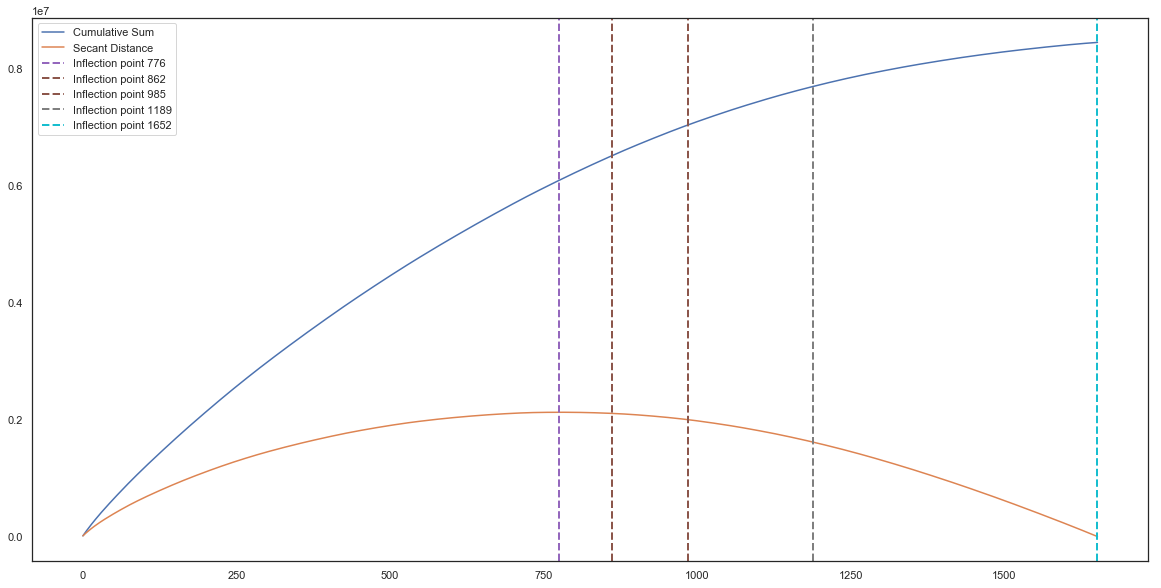

In [8]:
colon_lib.find_inflection(inflection_percentiles=[0,10,25, 50, 100])

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [9]:
colon_dr=dimension_reduction(colon_lib, 1189)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [10]:
%%time 
colon_dr.lib_size_normalize() 
colon_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
colon_dr.runPCA()
colon_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 8 neighbors
CPU times: user 11.9 s, sys: 787 ms, total: 12.7 s
Wall time: 9.85 s


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [11]:
colon_gate = gate_visualize(colon_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

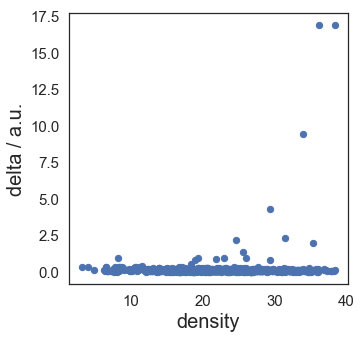

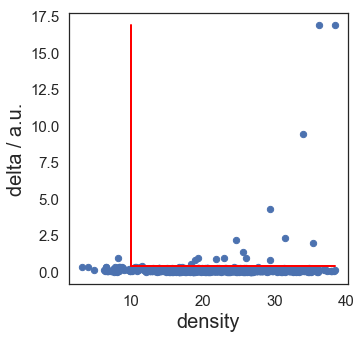

In [12]:
colon_gate.runDPC(colon_gate.UMAP,10,0.4) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

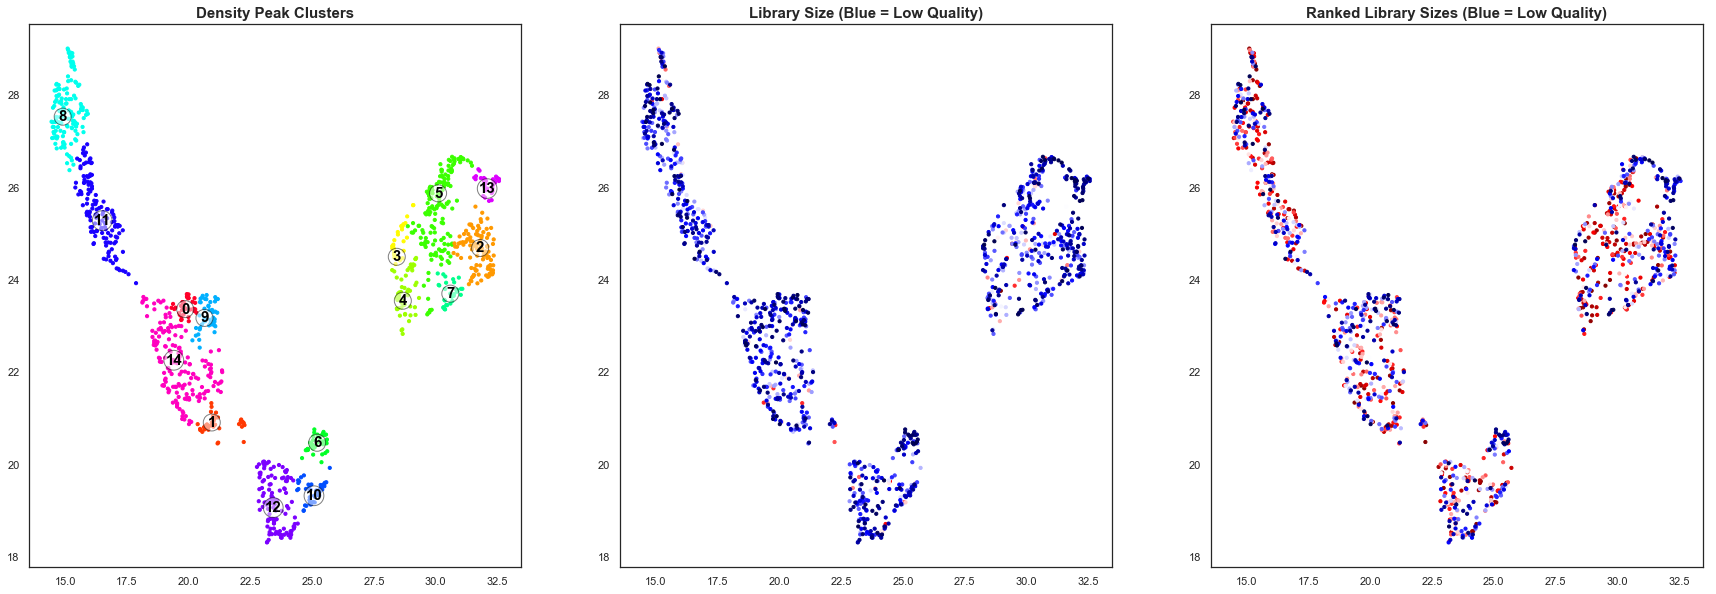

In [13]:
colon_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

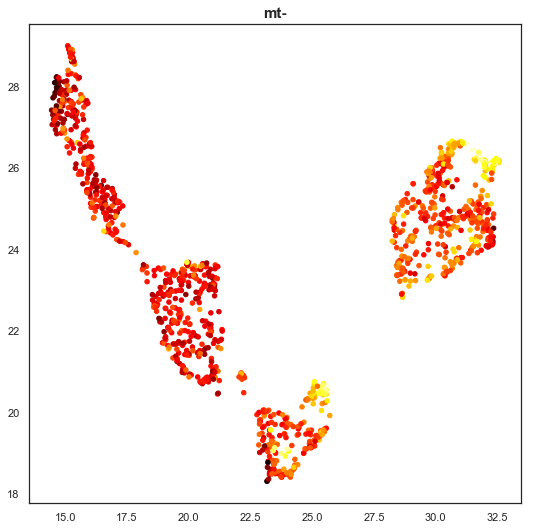

In [22]:
colon_gate.plotGenes(['mt-'])

Finally, we gate out clusters based on a combination of library metrics and the prior knowledge of target subpopulations. In this example, Clusters 10,11, and 12 are gated out due to their low library quality ranks. This function also returns the indices of cells after gating, which can be used to subset the original dataset for further analysis.

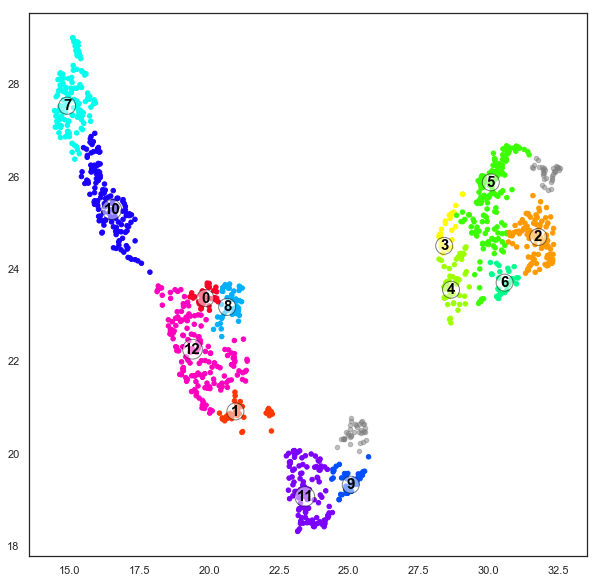

In [23]:
colon_remaining=colon_gate.manual_gating([6,13])

## Optional next iterations of quality control

We use the indices learned from the previous step to subset our original data so that we can further threshold library quality and gate cell subpopulations. 

In [24]:
second_run_data = colon_lib.lib_counts[colon_remaining]
second_run_cellID = colon_lib.lib_cellID[colon_remaining]

In [25]:
test_lib_second_run=library_data(second_run_data,second_run_cellID,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Inflection point at [ 515  428  349 1116] for [0, 15, 30, 100] percentiles of greatest secant distances


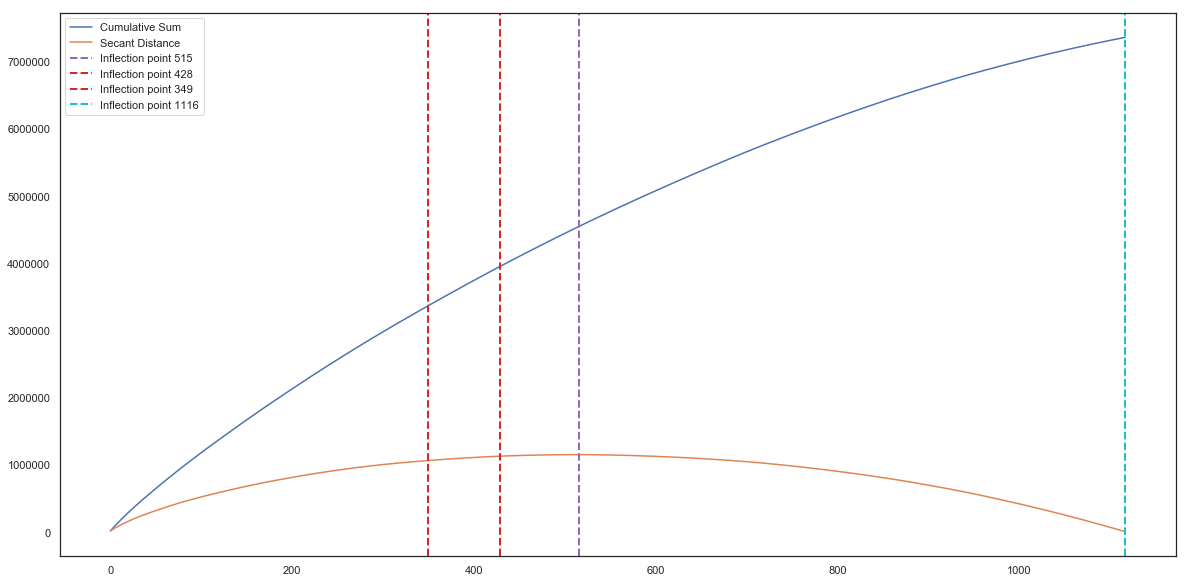

In [26]:
test_lib_second_run.find_inflection()

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [27]:
colon_dr=dimension_reduction(test_lib_second_run, 2119)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [28]:
%%time 
colon_dr.lib_size_normalize() 
colon_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
colon_dr.runPCA()
colon_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 5 neighbors
CPU times: user 6.79 s, sys: 618 ms, total: 7.4 s
Wall time: 4.7 s


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [29]:
colon_gate = gate_visualize(colon_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

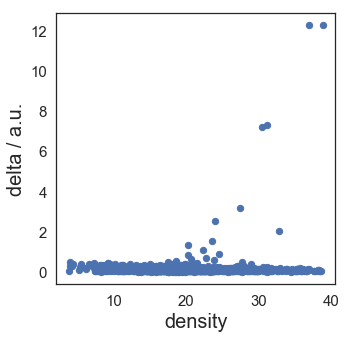

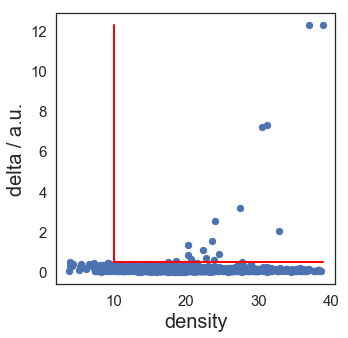

In [30]:
colon_gate.runDPC(colon_gate.UMAP,10,0.5) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

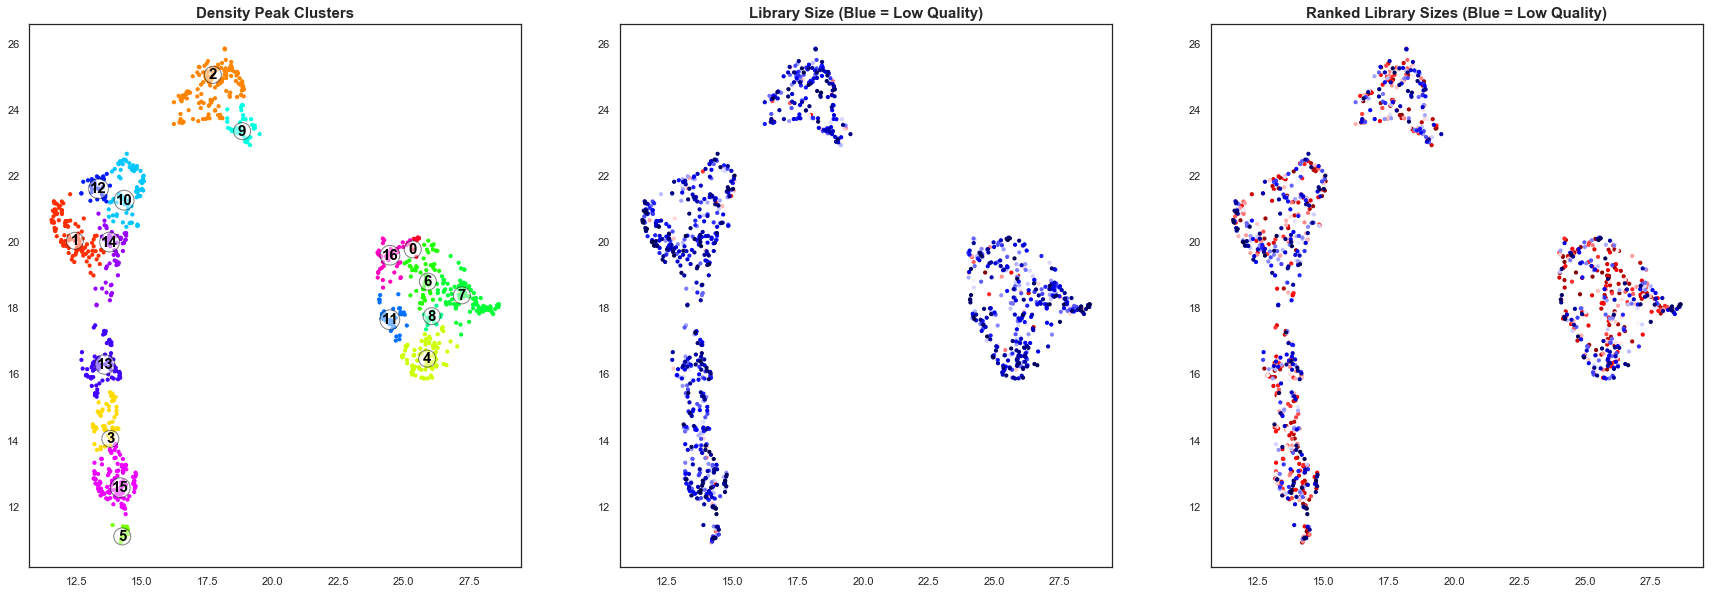

In [31]:
colon_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

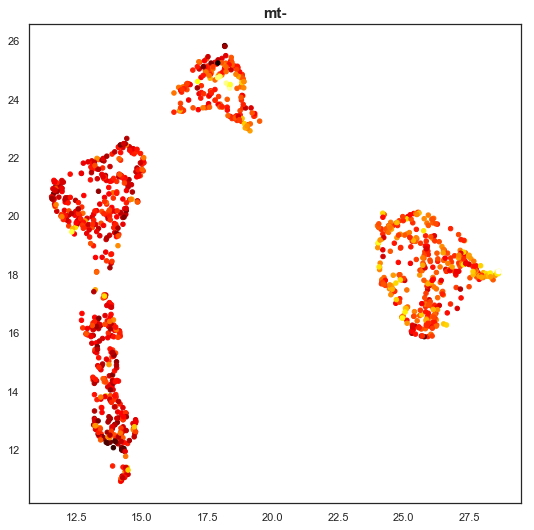

In [32]:
colon_gate.plotGenes(['mt-'])

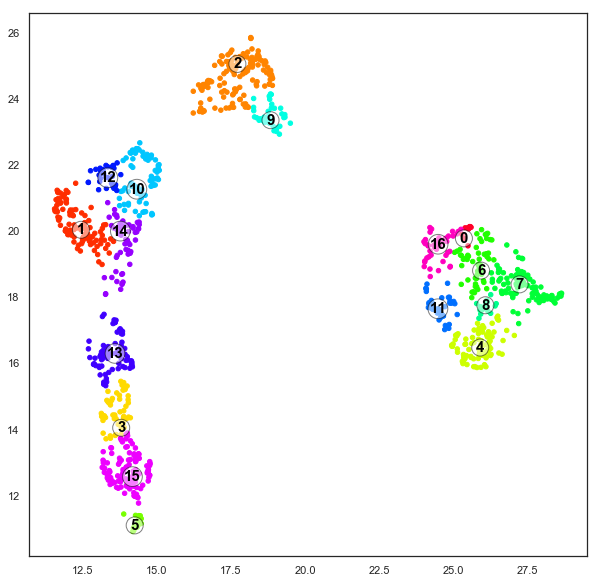

In [33]:
colon_remaining=colon_gate.manual_gating([])

## Data output 

We reconstruct a pandas dataframe for a quick check of the gated data and prepare it for writing to a .csv or any other format compatible with pandas dataframes.

In [34]:
colon_df = pd.DataFrame(test_lib_second_run.lib_counts[colon_remaining].toarray())
colon_df.index = test_lib_second_run.lib_cellID[colon_remaining]
colon_df.columns = test_lib_second_run.lib_geneID

In [35]:
colon_df.shape

(1117, 25505)

In [36]:
colon_df.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq_filtered_CH.tsv.gz', index=True, header=True, index_label='Cell', sep='\t', compression='gzip')

Now select 500 most variable genes and save to another file

In [72]:
colon_filtered = RNA_counts(colon_df)

In [73]:
colon_filtered_select = RNA_counts.var_select(counts_obj=colon_filtered, n_features=500)

In [76]:
colon_filtered_select.data.to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.tsv', sep='\t', header=True, index=True)

In [9]:
# output without cell labels for scvis
colon.data.astype('float64').to_csv('../inputs/GSM2743164_rep1_colon_rnaseq.processed.norowlabels.tsv', sep='\t', header=True, index=False)

---
# Retina Dataset

In [37]:
%time retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

CPU times: user 21 s, sys: 2.34 s, total: 23.4 s
Wall time: 23.7 s


In [38]:
retina.data.shape # check cells x genes

(6600, 20478)

Next, import the dataset for analysis. The QC preprocessing requires the data in three partitions.

1. Raw counts contained in a numpy.ndarray, as integers
2. Cell IDs in a 1-D numpy.ndarray, this can be barcodes or some other unique cell ID, with string datatype '<U16'
3. Gene IDs in a 1-D numpy.ndarray, these should be distinct gene names, with string datatype '<U16'

It also must be in a cell by gene, where each row represents a cell and each column represents a gene.

In [39]:
csr_counts=(retina.counts)
cellIDs=retina.cell_IDs
geneIDs=retina.gene_IDs

## Library_data object initialization for inflection point calculation and downstream operations

First, we pass the data organized above into a library_data object.

In [40]:
retina_lib=library_data(csr_counts,cellIDs,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Now we calculate the possible inflection points. This is done by finding the maximum distance between the cumulative sum curve and the secant line. These distances are then assigned a percentile score. By default, the inflection points are returned based off of four percentiles, 0, 15, 30 and 100. 0 represent the absolute maximum value for the aformentioned distance. 

A 15-30th percentile inflection point as to capture more libraries in preprocessing, using the 0th precentile runs the risk of cutting out useful, though relatively lower quality libraries. 

Inflection point at [1866 2197 1123 3863 6599] for [0, 10, 25, 50, 100] percentiles of greatest secant distances


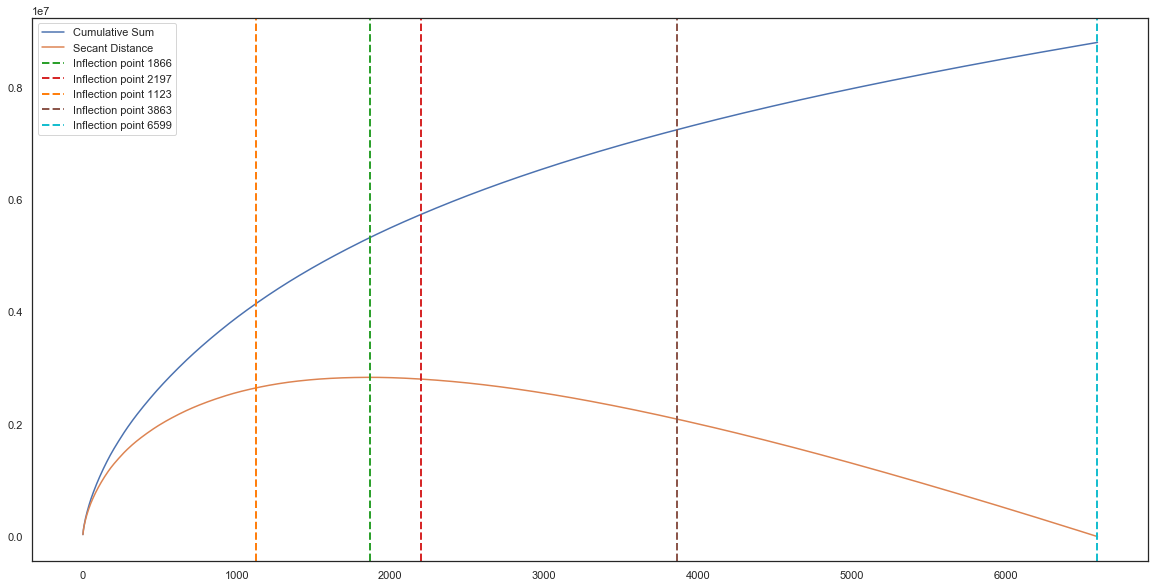

In [41]:
retina_lib.find_inflection(inflection_percentiles=[0,10,25, 50, 100])

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [42]:
retina_dr=dimension_reduction(retina_lib, 3863)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [43]:
%%time 
retina_dr.lib_size_normalize() 
retina_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
retina_dr.runPCA()
retina_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 33 neighbors
CPU times: user 22.5 s, sys: 1.8 s, total: 24.3 s
Wall time: 18.9 s


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [44]:
retina_gate = gate_visualize(retina_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

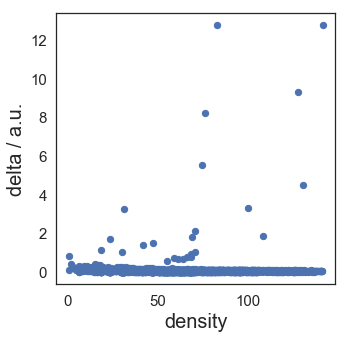

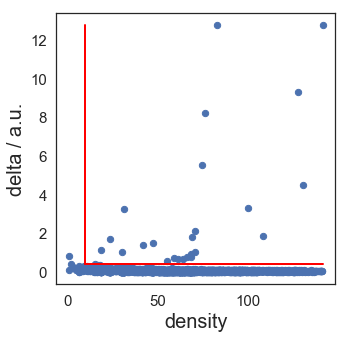

In [45]:
retina_gate.runDPC(retina_gate.UMAP,10,0.4) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

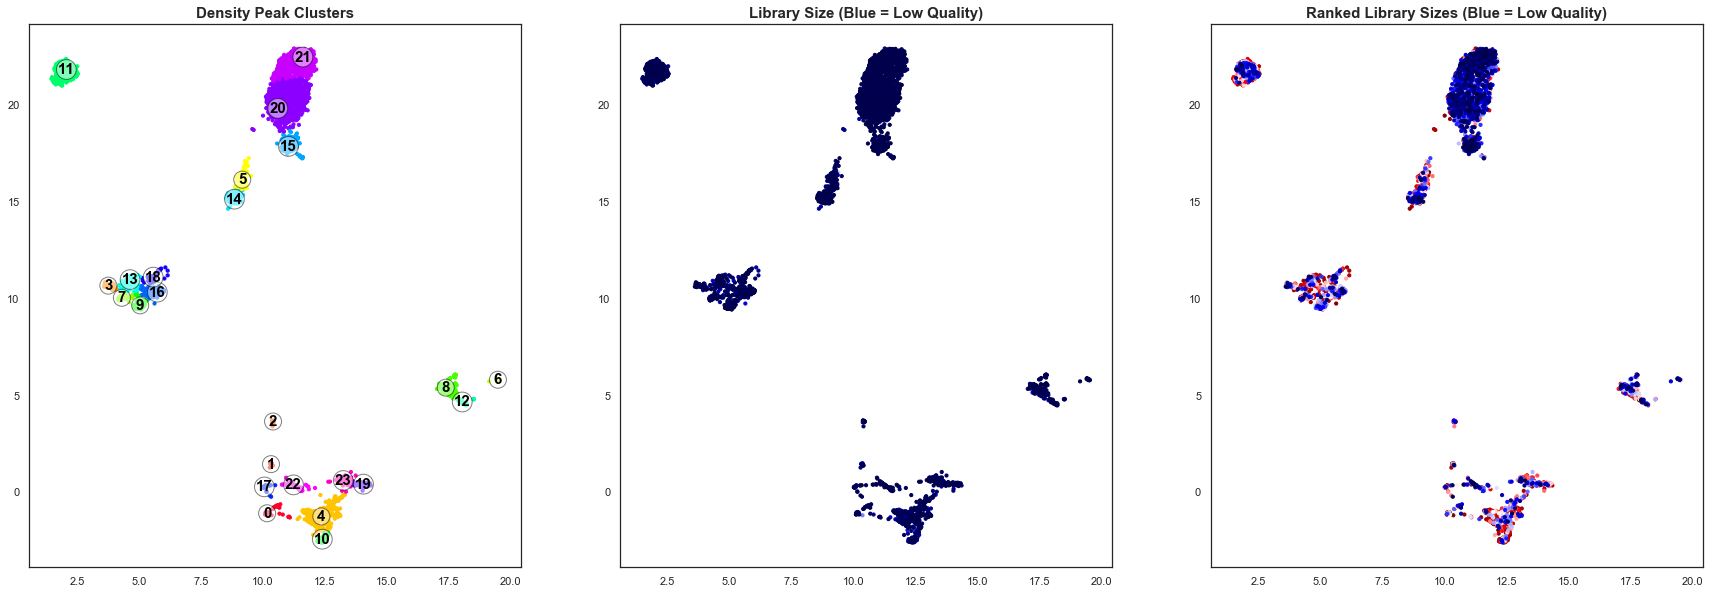

In [46]:
retina_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

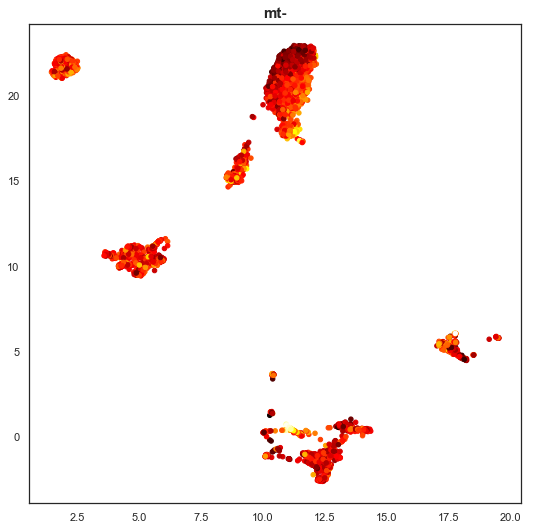

In [47]:
retina_gate.plotGenes(['mt-'])

Finally, we gate out clusters based on a combination of library metrics and the prior knowledge of target subpopulations. In this example, Clusters 10,11, and 12 are gated out due to their low library quality ranks. This function also returns the indices of cells after gating, which can be used to subset the original dataset for further analysis.

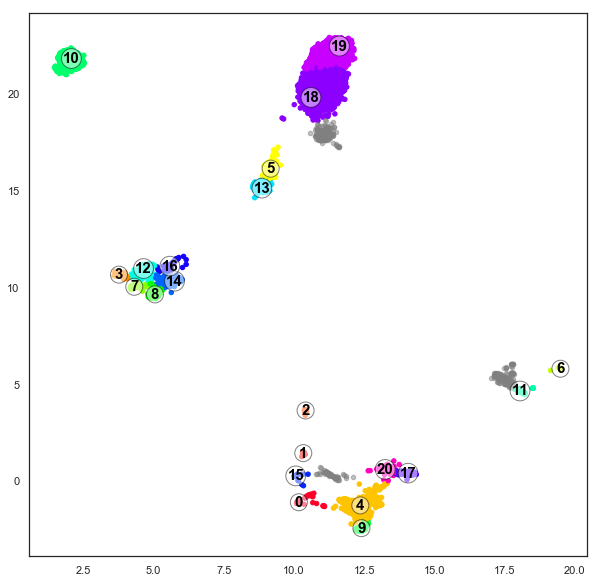

In [48]:
retina_remaining=retina_gate.manual_gating([15,22,8])

## Optional next iterations of quality control

We use the indices learned from the previous step to subset our original data so that we can further threshold library quality and gate cell subpopulations. 

In [49]:
second_run_data = retina_lib.lib_counts[retina_remaining]
second_run_cellID = retina_lib.lib_cellID[retina_remaining]

In [50]:
test_lib_second_run=library_data(second_run_data,second_run_cellID,geneIDs,sort=True) #It is preferable to sort the library sizes as downstream processes depend on this ordering.

Inflection point at [1041  798 1605 3428] for [0, 15, 30, 100] percentiles of greatest secant distances


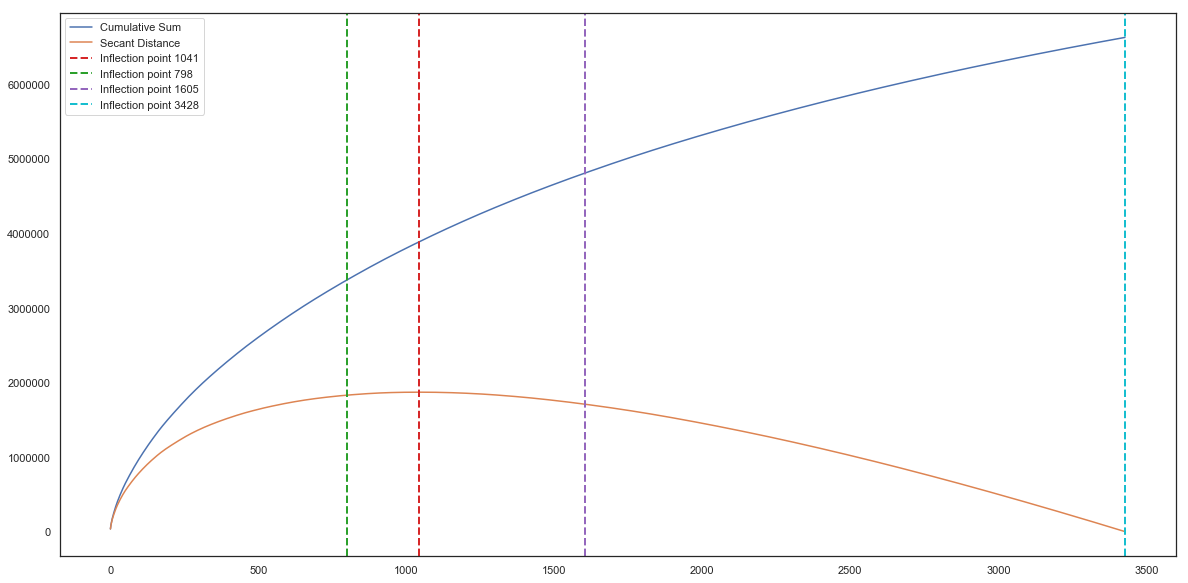

In [51]:
test_lib_second_run.find_inflection()

## Dimension_reduction for normalization, transformation, and dimensionality reduction

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [52]:
retina_dr=dimension_reduction(test_lib_second_run, 1605)

The general workflow involves normalization by library size, arcsinh transformation, PCA, and then a final 2-D embedding. 

In [53]:
%%time 
retina_dr.lib_size_normalize() 
retina_dr.arcsinh_transform() #log1p is also supported by .log1p_transform
retina_dr.runPCA()
retina_dr.runUMAP() #tSNE is also supported by .runTSNE

Running PCA for 100 components
Running UMAP with 17 neighbors
CPU times: user 9.07 s, sys: 680 ms, total: 9.75 s
Wall time: 6.6 s


## Gate_visualize for visualizing gene expression, library quality, and gating by cluster

We pass both the library_data object and selected inflection points into the dimension_reduction object to perform our embeddings and clusterings on.

In [54]:
retina_gate = gate_visualize(retina_dr)

Now, we perform Density Peak Clustering on our 2-D embedding. The points on the decision plot represent cells that act as cluster centers, and are separated based on delta/AU and density. Delta/AU represents the distance between the current cell and any other cell with higher density values. We simply cutoffs depending on these two parameters. Generally we just want to select clusters that have higher delta/a.u. values.

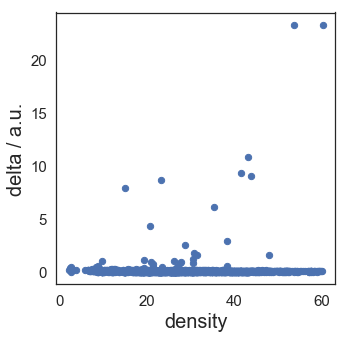

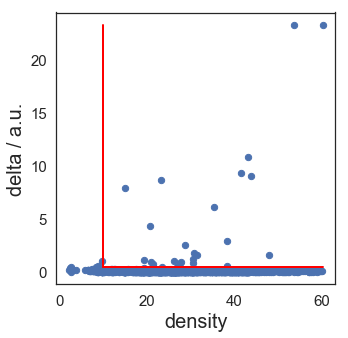

In [55]:
retina_gate.runDPC(retina_gate.UMAP,10,0.5) #first value = density cutoff, second value = delta/a.u. cutoff

Density peak clusters are visualized and overlayed with labels. Library can also be visualized, typically low library ranks/sizes should be gated out.

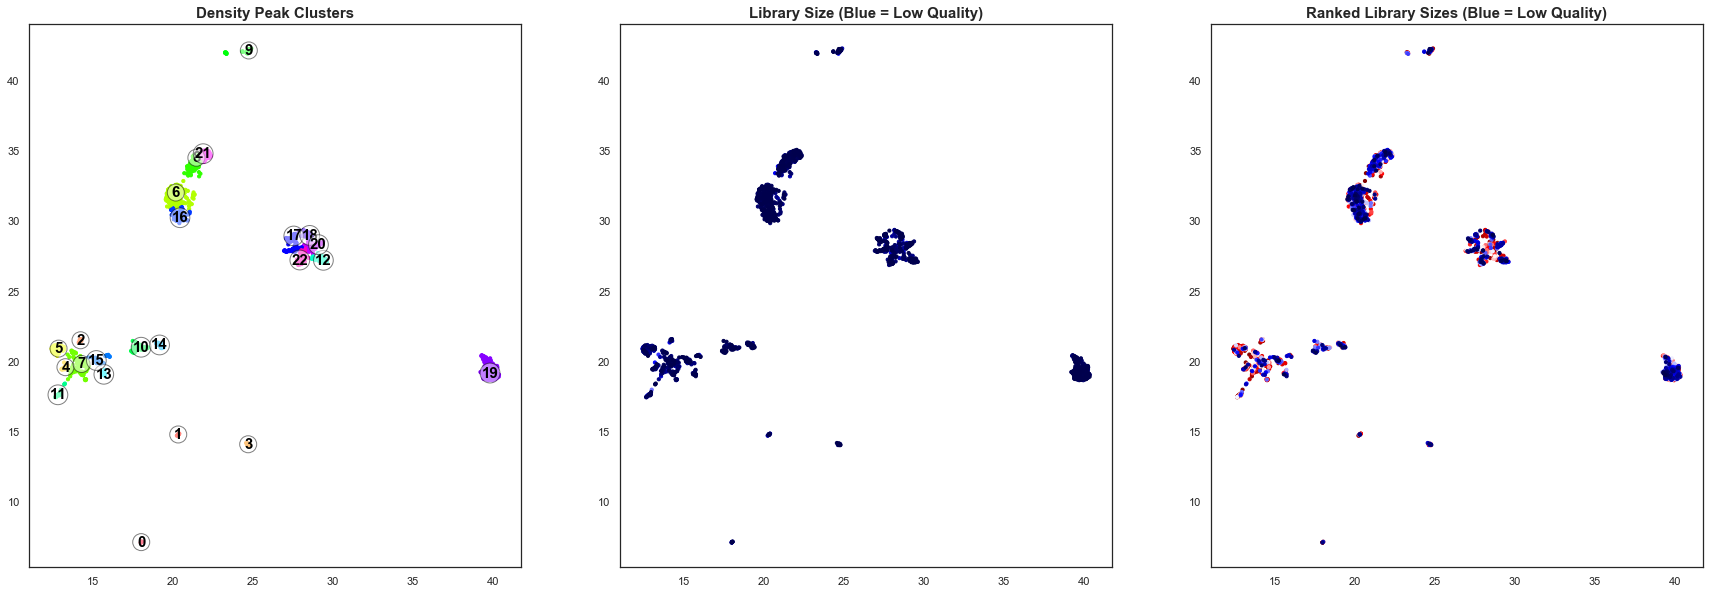

In [56]:
retina_gate.plotDPC()

The visualization of certain features can be done through the .plotGenes function. A list of strings is passed into the function and used as Regex patterns. For example, "mm10_" is used to find genes designated with mouse nomenclature, the overlay will depict the sum of all features detected with the pattern per cell. A maximum of 9 features can be visualized at once.

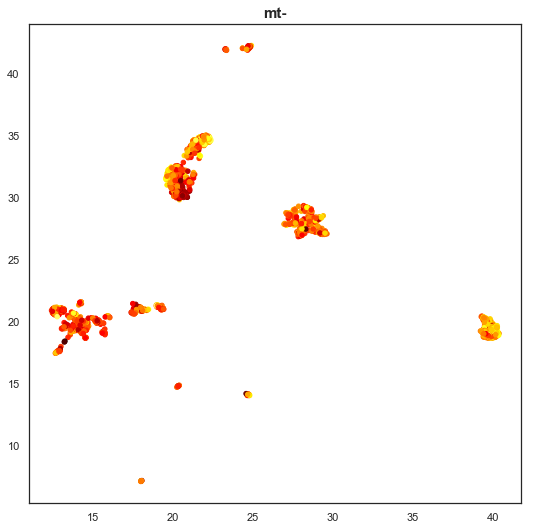

In [57]:
retina_gate.plotGenes(['mt-'])

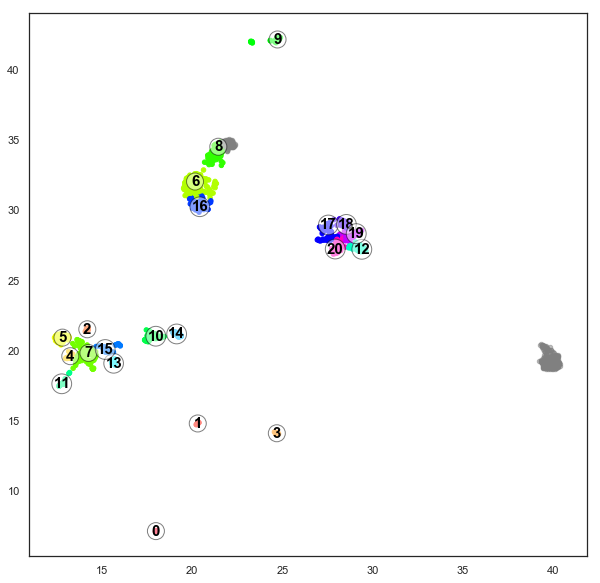

In [58]:
retina_remaining=retina_gate.manual_gating([19,21])

## Data output 

We reconstruct a pandas dataframe for a quick check of the gated data and prepare it for writing to a .csv or any other format compatible with pandas dataframes.

In [59]:
retina_df = pd.DataFrame(test_lib_second_run.lib_counts[retina_remaining].toarray())
retina_df.index = test_lib_second_run.lib_cellID[retina_remaining]
retina_df.columns = test_lib_second_run.lib_geneID

In [60]:
retina_df.shape

(1326, 20478)

In [61]:
retina_df.to_csv('../inputs/GSM1626793_P14Retina_1.digital_expression_filtered_CH.tsv.gz', index=True, header=True, index_label='Cell', sep='\t', compression='gzip')

Now select 500 most variable genes and save to another file

In [63]:
retina_filtered = RNA_counts(retina_df)

In [68]:
retina_filtered_select = RNA_counts.var_select(counts_obj=retina_filtered, n_features=500)

In [77]:
retina_filtered_select.data.to_csv('../inputs/GSM1626793_P14Retina_1.processed.tsv', sep='\t', header=True, index=True)

In [11]:
# output without cell labels for scvis
retina.data.astype('float64').to_csv('../inputs/GSM1626793_P14Retina_1.processed.norowlabels.tsv', sep='\t', header=True, index=False)